# Get Area-Elevation Curve

In [2]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### select the reservoir

In [56]:
start_date = '2023-07-21'
end_date = '2025-10-30'
RESERVOIR = 0

ALG_TYPE = 'swot'
DATA_DIR = Path('/tiger1/pdas47/resorr-swot/data/swot')

Barkley_Dam


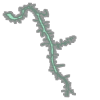

In [57]:
reservoir_boundaries = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))

selected_reservoirs = reservoir_boundaries['id'].tolist()
res_names = reservoir_boundaries[['id', 'name']].set_index('id').to_dict()['name']

RESERVOIR_NAME = res_names[RESERVOIR]
RESERVOIR_GDF = reservoir_boundaries[reservoir_boundaries['id'] == RESERVOIR]
RESERVOIR_GEOMETRY = RESERVOIR_GDF.geometry.iloc[0]

# get reservoir properties from GRanD
nominal_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_SKM'].values[0]
nominal_area_poly = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_POLY'].values[0]
max_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MAX'].values[0]
max_area = np.nan if max_area == -99 else max_area

min_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MIN'].values[0]
min_area = 0 if min_area == -99 else min_area

area_rep = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_REP'].values[0]
dam_height = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DAM_HGT_M'].values[0])
elev_msl = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['ELEV_MASL'].values[0])
depth = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DEPTH_M'].values[0])
capacity = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['CAP_MCM'].values[0])

print(RESERVOIR_NAME)

RESERVOIR_GEOMETRY

## Storage Calculation

In [58]:
aec_dir = Path('/tiger1/pdas47/resorr-swot/data/aec/insitu_aev')

In [59]:
aec_fp = aec_dir / f'{RESERVOIR}.csv'
aec_df = pd.read_csv(aec_fp, comment='#')

aec_df

,Elevation,Storage (mil. m3)
0,107.75,7.244621e+08
1,108.00,7.707717e+08
2,108.25,8.190384e+08
3,108.50,8.692623e+08
4,108.75,9.214434e+08
5,109.00,9.755816e+08
6,109.25,1.031677e+09
7,109.50,1.089730e+09
8,109.75,1.149739e+09
9,110.00,1.211706e+09


# Calculate storage using insitu aev.

In [60]:
import xarray as xr
import numpy as np


# inp_dir = Path('/tiger1/pdas47/tmsosPP/data/storage/icesat2/2324-insitu')
inp_dir = Path('/tiger1/pdas47/resorr-swot/data/swot/swot_karin')
fp = inp_dir / f'{RESERVOIR}.csv'

data = {
    'elevation': [],
    'date': [],
}

df = pd.read_csv(fp, parse_dates=['time'])
data['elevation'] = df['elevation']
data['date'] = df['time']
data['storage'] = np.interp(data['elevation'], aec_df['Elevation'], aec_df['Storage (mil. m3)'])

reservoir_dynamics = pd.DataFrame(data)
reservoir_dynamics = reservoir_dynamics.dropna()
reservoir_dynamics['storage_change'] = reservoir_dynamics['storage'].diff()
reservoir_dynamics['delta_t'] = reservoir_dynamics['date'].diff().dt.days
reservoir_dynamics

,elevation,date,storage,storage_change,delta_t
0,108.83777,2023-07-27,9.404502e+08,NaN,NaN
1,108.75053,2023-07-28,9.215581e+08,-1.889208e+07,1.0
2,108.22409,2023-08-28,8.140360e+08,-1.075221e+08,31.0
3,108.01456,2023-09-07,7.735827e+08,-4.045331e+07,10.0
4,107.93372,2023-09-08,7.584941e+08,-1.508864e+07,1.0
...,...,...,...,...,...
74,108.90820,2025-05-15,9.557020e+08,2.484620e+07,21.0
75,109.02136,2025-05-25,9.803744e+08,2.467235e+07,10.0
76,108.90719,2025-05-26,9.554833e+08,-2.489107e+07,1.0
77,108.93832,2025-06-05,9.622246e+08,6.741294e+06,10.0


2568100000.0


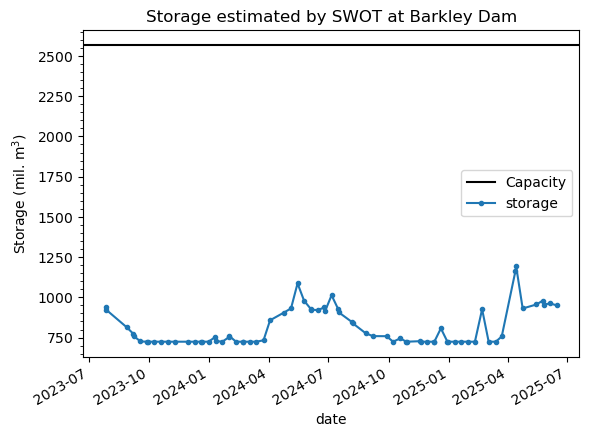

In [ ]:
from matplotlib import ticker

print(capacity * 1e6)

f, ax = plt.subplots()

if RESERVOIR_NAME == 'Old_Hickory_Dam':
    PERMANENT_POOL_VOL = 440352360
    PONDAGE_ALLOWED_FOR_POWER = 77709240
    SURCHARGE_FLOOD_STORE_VOL = 154185000

    ax.axhline(PERMANENT_POOL_VOL + PONDAGE_ALLOWED_FOR_POWER + SURCHARGE_FLOOD_STORE_VOL, color='lightgreen', label='Flood surcharge storage')
    ax.axhline(PERMANENT_POOL_VOL + PONDAGE_ALLOWED_FOR_POWER, color='Olive', label='Pondage allowed for power')
    ax.axhline(PERMANENT_POOL_VOL, color='Green', label='Permanent Pool')
else:
    ax.axhline(capacity * 1e6, label='Capacity', color='black')


reservoir_dynamics.plot(
    ax=ax,
    x='date',
    y='storage',
    marker='.'
)

ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6), useOffset=False, useMathText=True)

offset_text_artist = ax.yaxis.get_offset_text()
offset_text_artist.set_visible(False) # removing the x10^6 from plot. Specifying the unit in label.
ax.set_ylabel('Storage (mil. m$^3$)')

ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_title(f'Storage estimated by SWOT at {RESERVOIR_NAME.replace("_", " ")}')

ax.legend()

In [62]:
reservoir_dynamics.to_csv(f'/tiger1/pdas47/resorr-swot/data/storage/swot_karin/{RESERVOIR}.csv', index=False)